# Imports, Function Definitions and Environment Installation

In [0]:
!pip install -U git+https://github.com/python-visualization/folium

In [0]:
!pip install requests

In [0]:
!pip install -U networkx

In [0]:
import json
import operator
import requests
import itertools
import copy

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from google.cloud import bigquery
from google.colab import auth, files

In [0]:
auth.authenticate_user()
PROJECT_ID = 'bugseeker'
client = bigquery.Client(project=PROJECT_ID)

In [0]:
def plot_choropleth(_df, _col_name, _leg_name):
  """ Plot a choropleth map using a pandas dataframe and folium. """
  cc_json_raw = requests.get('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/countries.geo.lim.json').text  
  cc_json = json.loads(cc_json_raw)
  m = folium.Map(
    location=[4., -8],
    tiles='Mapbox Bright',
    zoom_start=2, no_wrap=True, max_bounds=True,
  )

  folium.Choropleth(
      geo_data=cc_json,
      name='choropleth',
      data=_df,
      columns=['country2', _col_name],
      key_on='feature.id',
      fill_color='YlOrRd',
      fill_opacity=0.7,
      line_opacity=0.2,
      legend_name=_leg_name
  ).add_to(m)

  return m

In [0]:
def draw_aid_network(_df_ppav_hdro, _df_aid_graph, _year, _topn_aid=10, _topn_donor=5):
  # get a map of country codes to names
  c2_to_name = {row['country2']:row['country_name'] for row_idx,row in _df_ppav_hdro.iterrows()}
    
  # get subset of data for given year
  y = pd.to_datetime(str(_year), format='%Y')
  i = _df_ppav_hdro.year == y
  df1 = _df_ppav_hdro[i]
  i = _df_aid_graph.year == y
  df2 = _df_aid_graph[i]
  
  # build a list of aid recipients and get the top
  aid_recipients = {row['country2']:row['aid_per_capita'] for row_idx,row in df1.iterrows()}
  aid_recipients_list = sorted(aid_recipients.items(), key=operator.itemgetter(1), reverse=True)  
  top_aid_recipients = [x[0] for x in aid_recipients_list[:_topn_aid]]
  top_aid_values = {x[0]:x[1] for x in aid_recipients_list[:_topn_aid]}
  all_countries = copy.deepcopy(top_aid_recipients)
    
  # pull bilateral relationships for the top recipients from the graph
  recipient_weights = dict()
  donor_name = lambda _c1,_c2,_c: _c1 if _c1 != _c else _c2 
  for c2 in top_aid_recipients:
    i = (df2.actor1 == c2) | (df2.actor2 == c2)
    df_sub = df2[i].copy()
    # sort the bilateral actions by number of mentions, get the top
    df_sub.sort_values('num_mentions', ascending=False, inplace=True)
    recipient_weights[c2] = dict()    
    for k in range(min(_topn_donor, len(df_sub))):
      c = donor_name(df_sub.iloc[k]['actor1'], df_sub.iloc[k]['actor2'], c2)
      recipient_weights[c2][c] = df_sub.iloc[k]['num_mentions']
      if c not in all_countries:
        all_countries.append(c)
                                 
  # build a graph from the data
  g = nx.Graph()
  for c in all_countries:
    g.add_node(c2_to_name.get(c, c))
  for c,edges in recipient_weights.items():
    cname = c2_to_name.get(c, c)
    for c2,w in edges.items():
      g.add_edge(cname, c2_to_name.get(c2, c2), weight=w)
  
  # compute node sizes for the recipients
  donor_size = 1500
  donor_color = '#81BEF7'
  
  recipient_min_size = 2500
  recipient_range = 3500
  recipient_color = '#FE642E'
  
  top_aid = list(top_aid_values.values())
  node_size_arr = list()
  node_color_arr = list()
  for c in all_countries:    
    
    if c in top_aid_recipients:
      aid_size = top_aid_values[c] / max(top_aid)
      recipient_size = int(aid_size*recipient_range + recipient_min_size)
      
      node_size_arr.append(recipient_size)      
      node_color_arr.append(recipient_color)
    else:
      node_size_arr.append(donor_size)
      node_color_arr.append(donor_color)
  
  # plot the graph  
  fig,ax = plt.subplots(figsize=(12, 12))
  nx.draw_spring(g, node_color=node_color_arr, alpha=0.75, with_labels=True, node_size=node_size_arr)   
  

In [0]:
def correlation_and_missing_data_analysis(_df, _feature_names, _nan_frac_thresh=0.60, _cc_thresh=0.95, _skip_cols=[]):
  """ This function does two things, eliminate features with a high fraction of missing data, and
      provide information about clustered features, so that a human decision can be made to
      discard all but one of clusters of correlated features.
      
      :param _df: The data frame
      :param _feature_names: A dictionary that maps column names to human-readable feature descriptions.
      :param _nan_frac_thresh: If a feature has greater than this fraction of NaNs, discard it.
      :param _cc_thresh: Features that have correlations >= cc_thresh are clustered together.  
      
      :returns df_clean, clustered_features: A new DataFrame with columns dropped with excessive NaNs, and a list
                list of feature ids, each list contains a list of feature_ids in a cluster.
  """
  
  df_clean = _df.copy()
  
  # compute the nan fraction for each column
  feature_ids = [k for k in _df.keys() if k not in _skip_cols]
  print(feature_ids)
  nan_fraction = {k:(np.isnan(_df[k]).sum() / len(_df)) for k in feature_ids}
  print('NaN fractions')
  print('-------------')
  for feature_id,nan_frac in sorted(nan_fraction.items(), key=operator.itemgetter(1), reverse=True):
    print('- {}: {:0.2f}'.format(_feature_names.get(feature_id, feature_id), nan_frac))
  
  # discard features based on NaN fractions
  features_to_drop = [feature_id for feature_id,nan_frac in nan_fraction.items() if nan_frac >= _nan_frac_thresh]
  for feature_id in features_to_drop:
    del df_clean[feature_id]
    
  # compute the correlation matrix in a nan-friendly way
  C = df_clean.corr().as_matrix()  
  
  # plot the correlation matrix between features
  fig = plt.figure(figsize=(12, 5))

  ax = plt.subplot(1, 2, 1)
  plt.imshow(C, aspect='auto', cmap=plt.cm.viridis)
  plt.grid(False)
  plt.colorbar()

  cvals = C[np.triu_indices(C.shape[0], k=1)].ravel()
  ax = plt.subplot(1, 2, 2)
  plt.hist(cvals, bins=20);

  # create a graph that contains the variables as nodes and the correlation coefficients as edge weights.
  # use a simple thresholding on edge weights to cluster the graph
  feature_ids = [x for x in list(df_clean.columns.values) if x not in _skip_cols]  
  assert len(feature_ids) == C.shape[0], "C.shape={}, len(feature_ids)={}".format(C.shape, len(feature_ids))
  g = nx.Graph()
  for feature_id in feature_ids:  
    g.add_node(feature_id)
  for k,feature_id1 in enumerate(feature_ids):
    for j in range(k):
      feature_id2 = feature_ids[j]
      if np.abs(C[k, j]) > _cc_thresh:
        g.add_edge(feature_id1, feature_id2) 

  # identify the connected components of the graph and print them out
  conn_comps = nx.connected_components(g)
  print('')
  print('Clustered features')  
  print('------------------')
  clustered_features = list()
  for grp in conn_comps:
    if len(grp) > 1:    
      # build up list of features and sort by nan fraction
      clustered_features.append(grp)
      grp_list = list(grp)
      grp_list.sort(key=lambda x: nan_fraction[x])
      for feature_id in grp_list:
        print('{} | {} (nanfrac={:0.2f})'.format(feature_id, _feature_names.get(feature_id, feature_id), nan_fraction[feature_id]))
      print('')

  return df_clean, clustered_features

# Global Humanitarian Aid Networks

The [GDELT Project](https://www.gdeltproject.org/data.html) offers an unprecedented view of world events as portrayed by the global media. The GDELT event database contains billions of machine annotated events processed from internet articles, updated every 15 minutes, and hosted on Google BigQuery. The purpose of this notebook is to aggregate information about humanitarian aid to countries and provide tools to visualize and understand the data.

**In this notebook, datasets have been aggregated from several sources and tools are built to visualize not just humanitarian aid, but also economic, health, and demographic information for countries around the world. In addition, a tool is developed to identify the top humanitarian aid recipients for a given year, as well as their donors, in a way that provides insight into the entire global aid network.**

## Introduction: Humanitarian Aid in a Nutshell

Not being an expert on aid, or a trained social scientist, or an economist, one can consult [wikipedia](https://en.wikipedia.org/wiki/Humanitarian_aid) and [the sources it cites](http://euhap.eu/upload/2014/09/the-state-of-art-of-humanitarian-action-2013.pdf) to gain a basic understanding about what humanitarian aid is and is not.

First and foremost, humanitarian aid seeks to provide **emergency response** to people in need, with the goal of saving lives and reducing human suffering, while preserving human dignity. Emergencies can be **man-made** or **natural**. Aid workers are trained to act in a manner that is **non-discriminatory** and **neutral** to sides involved in a conflict and governmental entities.

Modern humanitarian aid is administered by international agencies such as the **Red Cross** and the **United Nations**, and a plethora of other [non-governmental organizations (NGOs)](http://guides.lib.berkeley.edu/c.php?g=496970&p=3626027). These organizations provide medical assistance to wounded civilians in **war zones**, peace-keeping in **post-conflict areas**, distribute food to fight **world hunger**, provide services to **refugees**, and relief to those afflicted by **natural disaster**.

The effectiveness of foreign aid, that given from one government to another, can be **controversial**. When aid is ascribed  the goal of increasing a country's economic growth, the results are complex and debated, as described in [this article](https://www.weforum.org/agenda/2014/11/how-effective-is-foreign-aid/). In regards to food aid, it can sometimes be diverted to the wrong people, with negative consequences. For example, food aid to Somalia has been observed to be diverted to a [web of corrupt people and agencies](https://www.nytimes.com/2010/03/10/world/africa/10somalia.html). Foreign aid may be linked to the onset or exacerbation of violent conflict in receiving countries, as speculated in [this paper](http://www.michael-findley.com/uploads/2/0/4/5/20455799/worlddev_2011_gis-aid1.pdf). Optimizing the way in which humanitarian aid is distributed to those in need is an important problem that society faces.



## The Datasets

Two datasets are used in this notebook. The first dataset has yearly aggregated information from 186 countries for the years 2010-2016. It contains data from several sources:

1. GDELT Event Dataset: http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf
2. Human Development Reports, United Nations: http://hdr.undp.org/en/data
3. Development Data Hub Humanitarian Finance: http://data.devinit.org/global-picture/humanitarian-finance
4. World Bank Population Data by Country: https://data.worldbank.org/indicator/SP.POP.TOTL

As detailed in the Methods section, a significant amount of cleaning and preprocessing was undertaken to create the dataset, which is located here:

https://github.com/mschachter/fun_with_gdelt/blob/master/data/ppav_hdro_final.csv

The columns of the dataset are as follows:

<table>
  <tr><th>Column</th><th>Description</th></tr>
  <tr><td>country2,country_name</td><td>The two-letter country code and country name.</td></tr>
  <tr><td>year</td><td>The year that the data represents.</td></tr>
  <tr><td>population</td><td>The number of people in the country.</td></tr>
  <tr><td>popuation_{under5,15to64,over65}</td><td>Fraction of population under 5, 15-64, and over 65</td></tr>
  <tr><td>urban_population</td><td>Fraction of population living in urban areas.</td></tr>
  <tr><td>homocide_rate</td><td>Homicide rate per 100,000 people</td></tr>
  <tr><td>violence_metions</td><td>Fraction of the total number of violent event mentions in internet media, relative to all countries that year (GDELT database).</td></tr>
  <tr><td>mobile_phone_subscriptions</td><td>Mobile phone subscriptions (per 100 people)</td></tr>
  <tr><td>internet_users</td><td>Internet users (% of population)</td></tr>
  <tr><td>pupil_teacher_ratio</td><td>Pupil-teacher ratio, primary school (number of pupils per teacher)</td></tr>
  <tr><td>infant_mortality_rate</td><td>Infant mortality rate (per 1,000 live births)</td></tr>
  <tr><td>no_measles_immunization</td><td>Infants lacking immunization, measles (% of one-year-olds)</td></tr>
  <tr><td>expected_schooling</td><td>Expected Years of Schooling (of children)</td></tr>
  <tr><td>maternal_mortality</td><td>Maternal mortality ratio (deaths per 100,000 live births)</td></tr>
  <tr><td>forest_area</td><td>Forest area (% of total land area)</td></tr>
  <tr><td>renewable_energy_consumption</td><td>Renewable energy consumption (% of total final energy consumption)</td></tr>
  <tr><td>co2_emissions</td><td>Carbon dioxide emissions per capita (tonnes)</td></tr>
  <tr><td>rural_electricity</td><td>Rural population with access to electricity (%)</td></tr>
  <tr><td>gdp</td><td>Gross domestic product (GDP) per capita</td></tr>
  <tr><td>income_inequality</td><td>IHDI: Inequality in income</td></tr>
  <tr><td>gender_inequality_index</td><td>GII: Gender Inequality Index</td></tr>
  <tr><td>tourists</td><td>International inbound tourists (thousands)</td></tr>
  <tr><td>female_labor_rate</td><td>Labour force participation rate, female (% ages 15 and older)</td></tr>
  <tr><td>unemployment_rate</td><td>Total unemployment rate (% of labour force)</td></tr>
  <tr><td>agriculture_employment</td><td>Employment in agriculture (% of total employment)</td></tr>
  <tr><td>services_employment</td><td>Employment in services (% of total employment)</td></tr>
  <tr><td>working_poor</td><td>Working poor at PPP$3.10 a day (% of total employment)</td></tr>
  <tr><td>human_aid</td><td>Humanitarian Assistance Received (millions)</td></tr>
</table>


The second dataset is a yearly aggregate total of mentions of humanitarian aid events between countries for the years 2000-2018, from the GDELT events database. The dataset can be found here:

https://github.com/mschachter/fun_with_gdelt/blob/master/data/gdelt_human_aid_graph.csv

It contains the following columns:

<table>
<tr><th>Column</th><th>Description</th></tr>
<tr><td>year</td><td>The year the data was aggregated for.</td></tr>
<tr><td>actor1</td><td>The two letter country code for the first actor in the bilateral aid event.</td></tr>
<tr><td>actor2</td><td>The two letter country code for the second actor in the bilateral aid event.</td></tr>
<tr><td>event_count</td><td>The number of bilateral humanitarian aid events in a given year, normalized by the total number of events in that year.</td></tr>
<tr><td>num_mentions</td><td>The number of internet media mentions for bilateral aid events in a given year, normalized by the total number of events in that year.</td></tr>
</table>
    
  
  


## Interactive Map Widget for Visualizing Global Data

You can use the interactive map widget below to view dataset features as a function of country or year. This map widget can be *very* illustrative!. The map widget can be compared with [this visualization](http://data.devinit.org/global-picture/humanitarian-finance) as a reference.

In [0]:
# load the per country/year dataset and apply transformations to columns
df =  pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/ppav_hdro_final.csv',
                  keep_default_na=False, na_values=['nan'])
df['year'] = pd.to_datetime(df['year'], format='%Y-%m-%d')
df['aid_per_capita'] = df['human_aid'] / df['population']
df['log_aid'] = np.log10(df['aid_per_capita'] + 1e-8)
df['log_violent_mentions'] = np.log10(df['violent_mentions'] + 1e-8)

In [0]:
#@markdown Choose a quantity to view:
col_to_show = 'log_aid' #@param ['log_aid', 'aid_per_capita', 'population', 'population_15to64', 'population_over65', 'population_under5', 'urban_population', 'homicide_rate', 'log_violent_mentions', 'mobile_phone_subscriptions', 'internet_users', 'pupil_teacher_ratio', 'infant_mortality_rate', 'no_measles_immunization', 'expected_schooling', 'maternal_mortality', 'forest_area', 'renewable_energy_consumption', 'co2_emissions', 'rural_electricity', 'gdp', 'income_inequality', 'gender_inequality_index', 'tourists', 'female_labor_rate', 'unemployment_rate', 'agriculture_employment', 'services_employment', 'working_poor', 'human_aid']


#@markdown Choose a year to visualize data:
year_to_show = 2015 #@param {type:"slider", min:2000, max:2016, step:1}

col_label = '{} in {}'.format(col_to_show, year_to_show)

#@markdown Run this cell after changing the selection to view the map. Greyed-out countries don't have data.

i = df.year == pd.to_datetime('{}-01-01'.format(year_to_show))
plot_choropleth(df[i], col_to_show, col_label)

## Which Countries Receive the Most Aid, and from Who?

With a focus on the year 2016, we can quickly identify which countries receive the most aid per capita with the dataset. We can cross-reference the aid network dataset created from GDELT to get a feel for which aid donors are getting the most media attention from their contributions. For example, you should be able to see in 2016 that the largest aid recipients were a mix of African countries (Djibouti, Burundi, Central African Republic, DR Congo), Central and South American countries (Belize, Bolivia), Bosnia and Herzegovina, and Afghanistan. The United States was mentioned in the news as providing aid to DR Congo, Afghanistan, and Belize.

In [0]:
df_graph = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/gdelt_human_aid_graph.csv',
                       keep_default_na=False, na_values=['nan'])
df_graph['year'] = pd.to_datetime(df_graph['year'], format='%Y-%m-%d')

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


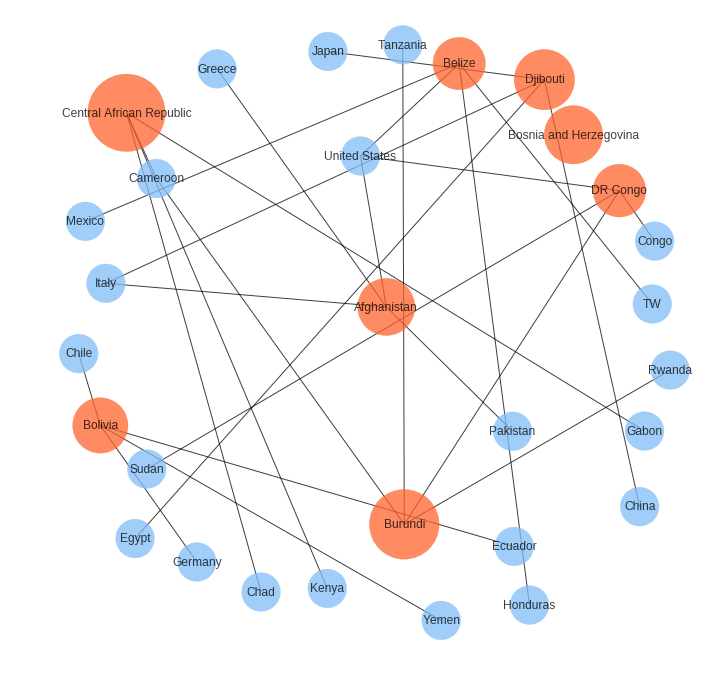

In [0]:
year_to_show = 2016 #@param {type:"slider", min:2010, max:2016, step:1}

number_of_recipients_to_show = 8 #@param {type:"slider", min:1, max:10, step:1}

number_of_donors_to_show = 4 #@param {type:"slider", min:1, max:5, step:1}

#@markdown Red nodes are aid recipients, blue nodes are putative aid donors.

draw_aid_network(df, df_graph, year_to_show,
                 _topn_aid=number_of_recipients_to_show,
                 _topn_donor=number_of_donors_to_show)

# Data Sources

1. GDELT Event Dataset: http://data.gdeltproject.org/documentation/GDELT-Data_Format_Codebook.pdf
2. Human Development Reports, United Nations: http://hdr.undp.org/en/data
3. Development Data Hub Humanitarian Finance: http://data.devinit.org/global-picture/humanitarian-finance
4. Development Data Hub Poverty: http://data.devinit.org/global-picture/poverty
5. ISO-ALPHA 3156 Two- and Three-letter Country Codes: https://gis.stackexchange.com/questions/1047/full-list-of-iso-alpha-2-and-iso-alpha-3-country-codes
6. World Bank Population Data by Country: https://data.worldbank.org/indicator/SP.POP.TOTL
7. World Countries GeoJSON: https://github.com/johan/world.geo.json


# Methods


## Exploring the GDELT Events Dataset

In this section, the GDELT database is explored in aggregate, without regard for event type, to provide some rationale for the choices made in the final analysis.

### Number of Events over Time

The GDELT project has aggregated global event information from 1979 to present day. The number of events recorded has increased exponentially over time, and logarithmically increases roughly in proportion to the world population, as the following plot shows:

In [0]:
# load world population file
df_world_population = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/world_population.csv')
df_world_population['Year'] = pd.to_datetime(df_world_population['Year'].astype('str'), format='%Y')
df_world_population.set_index('Year', inplace=True)
df_world_population['PopulationBillions'] = df_world_population['Population'] / 1e9

In [0]:
df_aid_yearly = client.query('''
SELECT
Year AS year,
Actor1CountryCode AS actor1_country_code,
Actor2CountryCode AS actor2_country_code,
COUNT(EventRootCode) AS event_count,
SUM(NumMentions) AS num_mentions

FROM `gdelt-bq.full.events`

WHERE
MonthYear >= 200001 AND MonthYear <= 201812
AND ActionGeo_Type = 1
AND EventBaseCode = '073'
AND Actor1CountryCode <> Actor2CountryCode
AND Actor1CountryCode IS NOT NULL
AND Actor2CountryCode IS NOT NULL

GROUP BY Year,EventBaseCode,Actor1CountryCode,Actor2CountryCode

ORDER BY Year,EventBaseCode
''').to_dataframe()
df_aid_yearly['year'] = pd.to_datetime(df_aid_yearly['year'].astype('int').astype('str'), format='%Y')


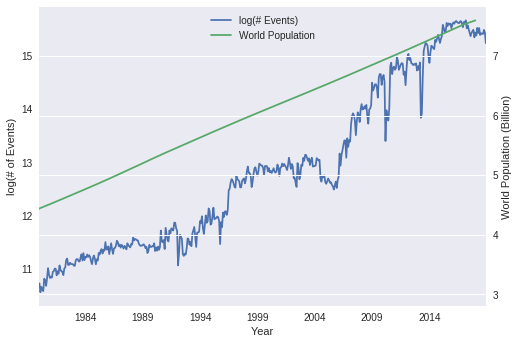

In [0]:
plt.figure()
ax = plt.subplot(111)
# ax_right = ax.twinx()
df_agg_events['log_event_count'] = np.log(df_agg_events['event_count'].values)
df_agg_events['log_event_count'].plot(ax=ax, label="log(# Events)")
plt.ylabel('log(# of Events)')
df_world_population['PopulationBillions'].plot(ax=ax, secondary_y=True, label='World Population')
plt.ylabel('World Population (Billion)')
plt.xlabel('Year')
ax.set_xlim(pd.Timestamp('1980-01-01'), pd.Timestamp('2018-12-30'))
lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')

### Event Importance over Time

GDELT offers a few different fields for judging event importance:

* NumArticles: the total number of source documents containing one or more mentions of this event during the 15 minute update in which it was first seen
* NumSources: the total number of information sources containing one or more mentions of this event during the 15 minute update in which it was first seen
* NumMentions:  the total number of mentions of this event across all source documents during the 15 minute update in which it was first seen.  Multiple references to an event within a single document also contribute to this count.

It was observed that the number of mentions and articles are closely matched, and the average number of sources per article is low. There is an acceleration in the number of articles per year that begins around 2006. The following query and plot demonstrates this:

In [0]:
df_importance_per_month = client.query('''
SELECT
MonthYear AS month_year,
SUM(NumMentions) / COUNT(EventCode) AS avg_num_mentions,
SUM(NumArticles) / COUNT(EventCode) AS avg_num_articles,
SUM(NumSources) / COUNT(EventCode) AS avg_num_sources
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812
GROUP BY MonthYear
ORDER BY MonthYear
''').to_dataframe()

df_importance_per_month = df_importance_per_month.dropna()
df_importance_per_month['month_year'] = \
   pd.to_datetime(df_importance_per_month['month_year'].astype('str'), format='%Y%m')
df_importance_per_month.set_index('month_year', inplace=True)

Text(0.5, 0, 'Year')

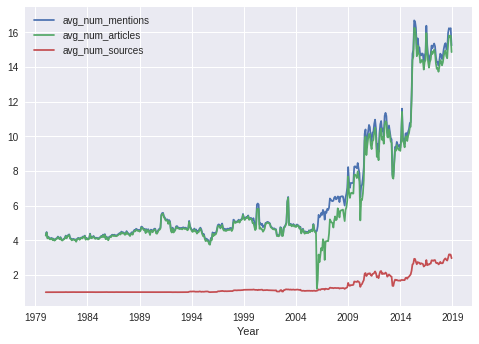

In [0]:
df_importance_per_month.plot()
plt.xlabel('Year')

### Distribution of Location Specifiers

The field ```ActionGeo_Type``` takes on one of the following values:
* 1: COUNTRY
* 2: USSTATE
* 3: USCITY
* 4: WORLDCITY
* 5: WORLDSTATE

Looking at the distribution of location specifiers over time, it seems like many of the events are at the city level globally, and there are also many events at the country level. Individual US states are well represented, but that is not true globally:

In [0]:
df_loc_spec_per_month = client.query('''
SELECT
MonthYear AS month_year,
ActionGeo_Type AS action_geo_type,
COUNT(ActionGeo_Type) AS action_geo_type_count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812 AND ActionGeo_Type IN (1, 2, 3, 4, 5)
GROUP BY MonthYear,ActionGeo_Type
ORDER BY MonthYear
''').to_dataframe()

df_loc_spec_per_month['month_year'] = \
   pd.to_datetime(df_loc_spec_per_month['month_year'].astype('str'), format='%Y%m')
df_loc_spec_per_month.set_index('month_year', inplace=True)

action_type_names = ['Country', 'US State', 'US City', 'World City', 'World State']
df_loc_spec_per_month['action_geo_type_cat'] = df_loc_spec_per_month['action_geo_type'].map(lambda x: action_type_names[x-1]).astype('category')

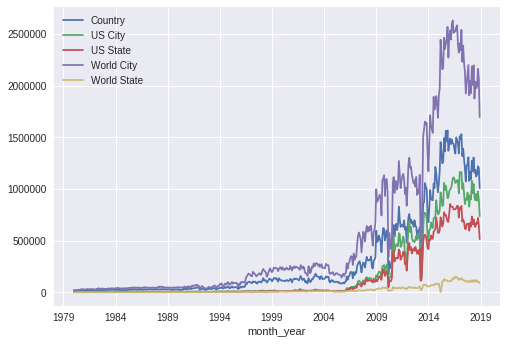

In [0]:
fig,ax = plt.subplots()
for key,grp in df_loc_spec_per_month.groupby('action_geo_type_cat'):
  grp['action_geo_type_count'].plot(label=key)
plt.legend()

### Impact and Tone

The GDELT database contains two numerical fields that try to quantify the impact and the sentiment (tone) of an event:

* Goldstein Scale: a numeric score from -10 to +10, capturing the theoretical potential impact that type of event will have on the stability of a country
* AvgTone: average “tone” of all documents containing one or more mentions of this event during the 15 minute update in which it was first seen.  The score ranges from -100 (extremely negative) to +100 (extremely positive).

There is also a hierarchy of codes that describe the nature of an event. The highest level code is the field "QuadClass", which is breaks an event down into four categories:

* 1: Verbal Cooperation
* 2: Material Cooperation
* 3: Verbal Conflict
* 4: Material Conflict

Obviously the impact and tone of an event will be heavily influenced by it's type, so the plot of impact and tone over time should be broken down by these categories. When examining the plot, the Goldstein scale seems relatively constant by QuadClass, as does the tone. The tone exhibits some weirdness around 2012:

In [0]:
df_impact_tone_per_month = client.query('''
SELECT
MonthYear AS month_year,
QuadClass AS quad_class,
AVG(GoldsteinScale) AS avg_goldstein_scale,
AVG(AvgTone) AS avg_tone
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812 AND ActionGeo_Type IN (1, 2, 3, 4, 5)
GROUP BY MonthYear,QuadClass
ORDER BY MonthYear
''').to_dataframe()

df_impact_tone_per_month['month_year'] = \
   pd.to_datetime(df_impact_tone_per_month['month_year'].astype('str'), format='%Y%m')
df_impact_tone_per_month.set_index('month_year', inplace=True)

quad_class_names = ['Verbal Cooperation', 'Material Cooperation', 'Verbal Conflict', 'Material Conflict']
df_impact_tone_per_month['quad_class_cat'] = df_impact_tone_per_month['quad_class'].map(lambda x: quad_class_names[x-1]).astype('category')

Text(0, 0.5, 'Avg Tone')

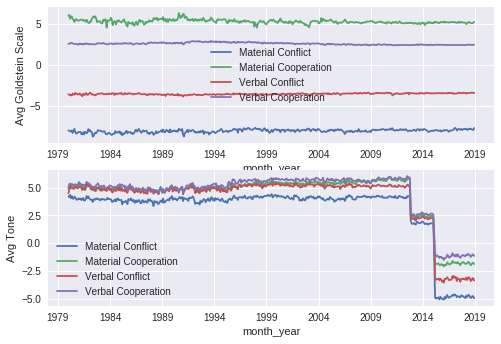

In [0]:
fig = plt.figure()

ax = plt.subplot(2, 1, 1)
for key,grp in df_impact_tone_per_month.groupby('quad_class_cat'):
  grp['avg_goldstein_scale'].plot(label=key)
plt.legend()
plt.ylabel('Avg Goldstein Scale')

ax = plt.subplot(2, 1, 2)
for key,grp in df_impact_tone_per_month.groupby('quad_class_cat'):
  grp['avg_tone'].plot(label=key)
plt.legend()
plt.ylabel('Avg Tone')


### Event Codes

Each event is coded in a hierarchical way. The "EventRootCode" field is broken down into the following values:

* 01: MAKE PUBLIC STATEMENT
* 02: APPEAL
* 03: EXPRESS INTENT TO COOPERATE
* 04: CONSULT
* 05: ENGAGE IN DIPLOMATIC COOPERATION
* 06: ENGAGE IN MATERIAL COOPERATION
* 07: PROVIDE AID
* 08: YIELD
* 09: INVESTIGATE
* 10: DEMAND
* 11: DISAPPROVE
* 12: REJECT
* 13: THREATEN
* 14: PROTEST
* 15: EXHIBIT FORCE POSTURE
* 16: REDUCE RELATIONS
* 17: COERCE
* 18: ASSAULT
* 19: FIGHT
* 20: USE UNCONVENTIONAL MASS VIOLENCE


In [0]:
df_event_root_code_per_month = client.query('''
SELECT
MonthYear AS month_year,
EventRootCode as event_root_code,
COUNT(EventRootCode) AS event_root_code_count
FROM `gdelt-bq.full.events`
WHERE MonthYear >= 198001 AND MonthYear <= 201812 AND
ActionGeo_Type IN (1, 2, 3, 4, 5)
AND EventRootCode IS NOT NULL
AND EventRootCode <> 'X'
AND EventRootCode <> '--'
GROUP BY MonthYear,EventRootCode
ORDER BY MonthYear,EventRootCode
''').to_dataframe()

In [0]:
df_event_root_code_per_month['month_year'] = \
   pd.to_datetime(df_event_root_code_per_month['month_year'].astype('str'), format='%Y%m')
df_event_root_code_per_month.set_index('month_year', inplace=True)

event_root_code_names = {
    '01': 'MAKE PUBLIC STATEMENT',
    '02': 'APPEAL',
    '03': 'EXPRESS INTENT TO COOPERATE',
    '04': 'CONSULT',
    '05': 'ENGAGE IN DIPLOMATIC COOPERATION',
    '06': 'ENGAGE IN MATERIAL COOPERATION',
    '07': 'PROVIDE AID',
    '08': 'YIELD',
    '09': 'INVESTIGATE',
    '10': 'DEMAND',
    '11': 'DISAPPROVE',
    '12': 'REJECT',
    '13': 'THREATEN',
    '14': 'PROTEST',
    '15': 'EXHIBIT FORCE POSTURE',
    '16': 'REDUCE RELATIONS',
    '17': 'COERCE',
    '18': 'ASSAULT',
    '19': 'FIGHT',
    '20': 'USE UNCONVENTIONAL MASS VIOLENCE'
}

df_event_root_code_per_month['event_root_code_cat'] = df_event_root_code_per_month['event_root_code'].map(lambda x: event_root_code_names[x]).astype('category')

In [0]:
unique_idx = df_event_root_code_per_month.index.unique()
years = [(k,x.year) for k,x in enumerate(unique_idx) if x.month == 1 and x.year % 5 == 0]
print(years)

[(0, 1980), (60, 1985), (120, 1990), (180, 1995), (240, 2000), (300, 2005), (360, 2010), (420, 2015)]


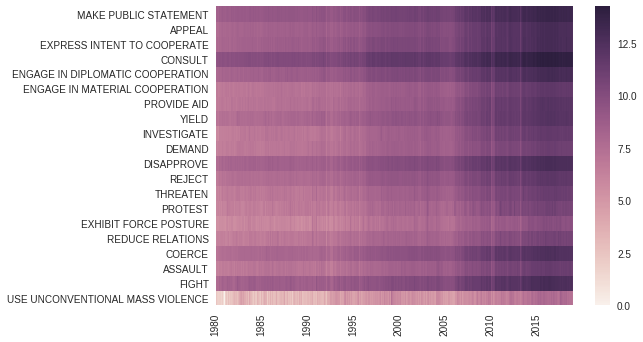

In [0]:
# build a matrix to make a heatmap with
sorted_code_names = [x[1] for x in sorted(event_root_code_names.items(), key=operator.itemgetter(0))]
unique_idx = df_event_root_code_per_month.index.unique()
event_code_time_matrix = np.zeros([len(sorted_code_names), len(unique_idx)])
for k,code_name in enumerate(sorted_code_names):
  i = df_event_root_code_per_month.event_root_code_cat == code_name
  idx = [np.where(unique_idx == d)[0][0] for d in df_event_root_code_per_month.index[i]]
  event_code_time_matrix[k, idx] = df_event_root_code_per_month.event_root_code_count[i].values

event_code_time_matrix = np.log(event_code_time_matrix + 1) 
xtks_years = [(k,x.year) for k,x in enumerate(unique_idx) if x.month == 1 and x.year % 5 == 0]
ytks = reversed(sorted_code_names)
  
fig,ax = plt.subplots()
sns.heatmap(event_code_time_matrix, ax=ax)
plt.xticks([x[0] for x in xtks_years])
ax.set_xticklabels([x[1] for x in xtks_years]);
ax.set_yticklabels(ytks, rotation=0);


## Construction of Final Datasets

For the analysis in this notebook, two main datasets were synthesized from a variety of sources:

1. **Aid Network Dataset**: bilateral humanitarian aid events from GDELT aggregated by year.
2. **Country Properties by Year Dataset**: data on countries by year, which includes population, poverty, humanitarian financial aid accepted, and number of violent events from GDELT, aggregated by year.



### Violent Events Dataset

An aggregation of violent events within a country for each year was constructed from the GDELT database as well. The query utilized the ActionGeo_CountryCode field and event root codes 17-20, which are events that involve coercion, assault, fighting, and unconvential mass violence.

In [0]:
df_violence = client.query('''
SELECT
Year AS year,
ActionGeo_CountryCode AS action_country_code,
COUNT(EventRootCode) AS event_count,
SUM(NumMentions) AS total_num_mentions

FROM `gdelt-bq.full.events`

WHERE MonthYear >= 200001 AND MonthYear <= 201812
AND ActionGeo_Type IN (1, 2, 3, 4, 5)
AND EventRootCode IN ('17', '18', '19', '20')

GROUP BY Year,ActionGeo_CountryCode

ORDER BY Year,ActionGeo_CountryCode
''').to_dataframe()
df_violence['year'] = pd.to_datetime(df_violence['year'].astype('int').astype('str'), format='%Y')

In [0]:
df_violence.to_csv('gdelt_violence.csv', index=False)
files.download('gdelt_violence.csv')

### Violence, Poverty, Aid, and Population by Country and Year Dataset

The dataset was supplemented with non-GDELT data, by merging several datasets into one:

1. Development Data Hub Humanitarian Finance: http://data.devinit.org/global-picture/humanitarian-finance
2. Development Data Hub Poverty: http://data.devinit.org/global-picture/poverty
3. Development Data Hub Government Revenue: http://data.devinit.org/global-picture/government-finance
4. ISO-ALPHA 3156 Two- and Three-letter Country Codes: https://gis.stackexchange.com/questions/1047/full-list-of-iso-alpha-2-and-iso-alpha-3-country-codes
5. World Bank Population Data by Country: https://data.worldbank.org/indicator/SP.POP.TOTL

The following code accomplishes this synthesis:

In [0]:
df_countries = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/country_codes.csv',
						               keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
c2_c3 = {row['Country2']:row['Country3'] for row_idx,row in df_countries.iterrows()}
c3_c2 = {row['Country3']:row['Country2'] for row_idx,row in df_countries.iterrows()}
cname_c2 = {row['Country']:row['Country2'] for row_idx,row in df_countries.iterrows()}
c2_cname = {row['Country2']:row['Country'] for row_idx,row in df_countries.iterrows()}
fips_c2 = {row['fips']:row['Country2'] for row_idx,row in df_countries.iterrows()}

# load the humanitarian finance dataset
df_human_finance = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/ddh_humanitarian_assistance.csv',
								               keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_human_finance['year'] = pd.to_datetime(df_human_finance['year'].astype('str'), format='%Y')
i = (df_human_finance['year'] >= pd.to_datetime('2000-01-01')) & (df_human_finance['year'] <= pd.to_datetime('2018-12-31'))
df_human_finance = df_human_finance[i]
df_human_finance['country2'] = df_human_finance['country2'].astype('category')
df_human_finance.set_index(['country2', 'year'], inplace=True)
del df_human_finance['country_name']

# load the poverty dataset
df_poverty = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/ddh_poverty.csv',
						             keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_poverty['year'] = pd.to_datetime(df_poverty['year'].astype('str'), format='%Y')
i = (df_poverty['year'] >= pd.to_datetime('2000-01-01')) & (df_poverty['year'] <= pd.to_datetime('2018-12-31'))
df_poverty = df_poverty[i]
df_poverty['country2'] = df_poverty['country2'].astype('category')
df_poverty.set_index(['country2', 'year'], inplace=True)
del df_poverty['country_name']

# load the world population by country and year dataset
df_worldpop = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/world_population_by_country_flat_with2018.csv',
            						  keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_worldpop['year'] = pd.to_datetime(df_worldpop['year'].astype('str'), format='%Y')
df_worldpop['country2'] = df_worldpop['country3'].map(lambda x: c3_c2.get(x, 'MISSING'))
i = df_worldpop['country2'] != 'MISSING'
df_worldpop =  df_worldpop[i]
i = (df_worldpop['year'] >= pd.to_datetime('2000-01-01')) & (df_worldpop['year'] <= pd.to_datetime('2018-12-31'))
df_worldpop = df_worldpop[i]
df_worldpop['country2'] = df_worldpop['country2'].astype('category')
df_worldpop.set_index(['country2', 'year'], inplace=True)
del df_worldpop['country3']

# load the gdelt violence dataset
df_violence = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/gdelt_violence.csv',
						              keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])	
df_violence.rename(columns={'event_count':'violent_event_count',
                            'total_num_mentions':'violent_num_mentions',
                            'action_country_code':'country2'}, inplace=True)
df_violence['year'] = pd.to_datetime(df_violence['year'].astype('str'), format='%Y-%m-%d')

i = [x in fips_c2 for x in df_violence['country2']]
df_violence = df_violence[i]
df_violence['country2'] = [fips_c2[x] for x in df_violence['country2']]
df_violence.set_index(['country2', 'year'], inplace=True)

# join all the datasets
df_pop_pov_aid_vio = pd.merge(df_worldpop, df_human_finance, left_index=True, right_index=True, how='outer')
df_pop_pov_aid_vio = pd.merge(df_pop_pov_aid_vio, df_poverty, left_index=True, right_index=True, how='outer')
df_pop_pov_aid_vio = pd.merge(df_pop_pov_aid_vio, df_violence, left_index=True, right_index=True, how='outer')

# exclude some countries that have been found to have missing population data
excluded_countries = ['AI', 'CK', 'EH', 'FK', 'GF', 'GP', 'MQ', 'MS', 'PM', 'RE', 'TK', 'TW', 'VA', 'YT', 'WF']
i = np.array([idx[0] in excluded_countries for idx in df_pop_pov_aid_vio.index])
df_pop_pov_aid_vio = df_pop_pov_aid_vio[~i]
df_pop_pov_aid_vio.sort_index(inplace=True)

# add a column for readable country name, remove rows with no corresponding country name
df_pop_pov_aid_vio['country_name'] = [c2_cname.get(idx[0], 'MISSING') for idx in df_pop_pov_aid_vio.index]
i = df_pop_pov_aid_vio['country_name'] == 'MISSING'
df_pop_pov_aid_vio = df_pop_pov_aid_vio[~i]

# fill in missing values for numeric columns with NaNs, convert to float. there shouldn't be any empty
# strings in the categorical or date columns
df_pop_pov_aid_vio = df_pop_pov_aid_vio.replace('', np.nan)
for col_name in ['population', 'human_aid', 'poverty', 'violent_event_count', 'violent_num_mentions']:
  df_pop_pov_aid_vio[col_name] = df_pop_pov_aid_vio[col_name].astype('float')

In [0]:
df_pop_pov_aid_vio.to_csv('pop_pov_aid_vio.csv', header=True, index=True, na_rep='nan')
files.download('pop_pov_aid_vio.csv')

### Dealing with Missing Humanitarian Aid Data

Unfortunately there is missing poverty and aid data for a number of countries. Many of the countries missing data are small and won't impact analysis very much. Other countries, such as Afghanistan and Somalia, would be significant losses because they are known to receive a lot of aid. In a later section, this dataset will be merged with a rich dataset, the Human Development Reports Data, that may help to fill the gaps.

In [0]:
df_pop_pov_aid_vio =  pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/pop_pov_aid_vio.csv',
                                  keep_default_na=False, na_values=['nan'])
df_pop_pov_aid_vio['year'] = pd.to_datetime(df_pop_pov_aid_vio['year'], format='%Y-%m-%d')
df_pop_pov_aid_vio['country2'] = df_pop_pov_aid_vio['country2'].astype('category')
df_pop_pov_aid_vio.describe()

,human_aid,poverty,violent_event_count,violent_num_mentions
count,3298.000000,2.880000e+03,4.133000e+03,4.133000e+03
mean,49.629667,7.092711e+06,1.602891e+04,2.041636e+05
std,171.636954,3.477996e+07,1.138759e+05,1.868358e+06
min,-0.031549,0.000000e+00,1.000000e+00,2.000000e+00
25%,0.000000,2.455475e+04,2.960000e+02,1.772000e+03
50%,2.072716,2.824382e+05,1.636000e+03,1.005100e+04
75%,19.431356,3.375304e+06,6.751000e+03,5.407800e+04
max,2746.179305,4.749667e+08,3.233492e+06,6.030687e+07


In [0]:
# look at the nan count by country
def nan_frac(x):
  return np.isnan(x).sum() / len(x)
df_nanfrac = df_pop_pov_aid_vio.groupby('country_name').aggregate(nan_frac)
df_nanfrac.reset_index(inplace=True)
df_nanfrac.sort_values('human_aid', inplace=True);

The following plot shows that many countries have 90% of the aid data filled in, but there are a set of countries with no aid data:

Text(0, 0.5, 'NaN fraction for human_aid')

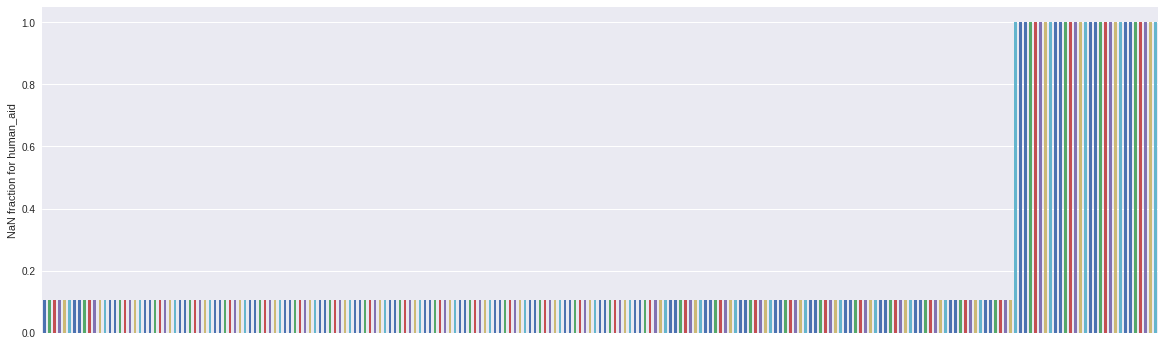

In [0]:
fig,ax = plt.subplots(figsize=(20, 6))
df_nanfrac['human_aid'].plot(kind='bar', by='country_name')
plt.xticks([])
plt.ylabel('NaN fraction for human_aid')

In [0]:
# drop the rows with nans in them, check out the difference in summary statistics
df_pop_pov_aid_vio_limited = df_pop_pov_aid_vio.dropna()
df_pop_pov_aid_vio_limited.describe()

,human_aid,poverty,violent_event_count,violent_num_mentions
count,2549.000000,2.549000e+03,2.549000e+03,2.549000e+03
mean,57.166642,7.733976e+06,1.784459e+04,2.085170e+05
std,186.122759,3.668315e+07,1.189638e+05,1.821577e+06
min,-0.031549,0.000000e+00,1.000000e+00,2.000000e+00
25%,0.292682,3.806433e+04,5.880000e+02,3.330000e+03
50%,4.080108,3.966520e+05,2.156000e+03,1.352900e+04
75%,28.131685,3.986271e+06,7.588000e+03,5.955500e+04
max,2746.179305,4.749667e+08,3.233492e+06,6.030687e+07


In [0]:

# print out the countries that have been lost
countries_with_full_data = df_pop_pov_aid_vio_limited.country2.unique()
lost_countries = [c for c in df_pop_pov_aid_vio.country2.unique() if c not in countries_with_full_data]
print('Dropping NA rows lead to the loss of {} countries:'.format(len(df_pop_pov_aid_vio.country2.unique()) - len(df_pop_pov_aid_vio_limited.country2.unique())))
c2_name = {row['country2']:row['country_name'] for _,row in df_pop_pov_aid_vio.iterrows()}
lost_countries_names = [c2_name[c] for c in lost_countries if c in c2_name];
sorted(lost_countries_names)


Dropping NA rows lead to the loss of 73 countries:


['Afghanistan',
 'American Samoa',
 'Andorra',
 'Antarctica',
 'Antigua and Barbuda',
 'Argentina',
 'Aruba',
 'Bahamas',
 'Bahrain',
 'Barbados',
 'Bermuda',
 'Bouvet Island',
 'British Indian Ocean Territory',
 'British Virgin Islands',
 'Brunei',
 'Cambodia',
 'Cayman Islands',
 'Christmas Island',
 'Cuba',
 'Dominica',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Faroe Islands',
 'Finland',
 'France',
 'French Polynesia',
 'Gibraltar',
 'Greenland',
 'Grenada',
 'Guam',
 'Heard Island and McDonald Islands',
 'Hong Kong',
 'Iceland',
 'Ireland',
 'Isle of Man',
 'Kuwait',
 'Latvia',
 'Libya',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Macau',
 'Marshall Islands',
 'Monaco',
 'Namibia',
 'Nauru',
 'Netherlands',
 'New Caledonia',
 'New Zealand',
 'Niue',
 'Norfolk Island',
 'North Korea',
 'Northern Mariana Islands',
 'Norway',
 'Oman',
 'Palau',
 'Pitcairn',
 'Puerto Rico',
 'Qatar',
 'Saint Helena, Ascension and Tristan da Cunha',
 'Saint Kitts and Nevis',
 'Saint Martin',

### Normalizing GDELT Events Over Time

A significant observation of the GDELT dataset is that the number of reported violent events grows pretty nonlinearly over time. This is not because the world becomes exponentially more violent every year; it's due to improvements in technology and new sources of information being added to the GDELT database over time. After observing this effect, the choice was made to normalize the count of violent events and the number of mentions of violent events by the total sum across countries each year.



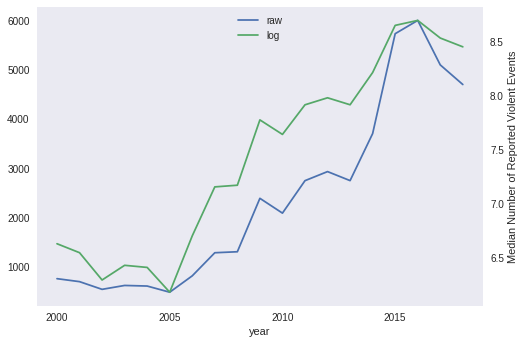

In [0]:
# group by year across countries and compute the median
df_yearly_mean = df_pop_pov_aid_vio.groupby('year').aggregate(np.median)
df_yearly_mean['log_violent_event_count'] = np.log(df_yearly_mean['violent_event_count'])

# plot the average number of events over time
fig,ax = plt.subplots()
df_yearly_mean['violent_event_count'].plot(label='raw', ax=ax)
df_yearly_mean['log_violent_event_count'].plot(ax=ax, secondary_y=True, label='log')
plt.ylabel('Median Number of Reported Violent Events')
plt.xlabel('Year')
lines = ax.get_lines() + ax.right_ax.get_lines()
ax.legend(lines, [l.get_label() for l in lines], loc='upper center')
plt.grid(False)

The following code accomplishes this normalization:

In [0]:
# sum violent mentions across years
df_yearly_sum = df_pop_pov_aid_vio.groupby('year').aggregate(np.sum)

In [0]:
num_mentions_map = {row_idx:row['violent_num_mentions'] for row_idx,row in df_yearly_sum.iterrows()}
df_normed = df_pop_pov_aid_vio.copy()
df_normed.set_index(['year', 'country2'], inplace=True)
df_normed['violent_num_mentions_frac'] = [
    row['violent_num_mentions'] / num_mentions_map[row_idx[0]] for row_idx,row in df_normed.iterrows()
]
# remove non-normalized columns
del df_normed['violent_num_mentions']
del df_normed['violent_event_count']

In [0]:
df_normed.to_csv('pop_pov_aid_vio_norm.csv', header=True, index=True, na_rep='nan')
files.download('pop_pov_aid_vio_norm.csv')

### Dealing with Missing Data and Correlated Variables in Human Development Reports Dataset

The [Human Development Reports](http://hdr.undp.org/en/data) are a rich source of country/year level data. They provide a large sample of indices for quantifying economic, environmental, demographic, and governmental features about a country.

Through an API that they provide, data was downloaded for a variety of indices and explored. There are many correlated indices, and the one task is to reduce the dataset into a set of usable and minimally correlated indices. The other task is to figure out how to deal with so much missing data.

In [0]:
# load the file with indicators in it
df = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/hdro_indicators.tsv', delimiter='\t')
id_to_desc = {str(row['indicator_id']):row['description'] for row_idx,row in df.iterrows()}

In [0]:
# load up the flat indices file
df = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/hdro_indices_flat.csv')

df['country3'] = df['country3'].astype('category')
df['indicator'] = df['indicator'].astype('str').astype('category')
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [0]:
# un-melt the flat dataset of indices
df_piv = df.pivot_table(index=['year', 'country3'], columns=['indicator'])

In [0]:
# rename the columns to just be the string representation of the indicator id
df_piv.columns = [c[1] for c in df_piv.columns]

In [0]:
# filter out data to only include years already known to contain the bulk of the data
i = (df_piv.index.get_level_values('year') >= pd.to_datetime('2010', format='%Y')) & (df_piv.index.get_level_values('year') <= pd.to_datetime('2016', format='%Y'))
df_piv = df_piv[i]

Features that had more than 60% of their rows equal to NaN were removed. A correlation analysis was performed to search for clusters of correlated features:

NaN fractions
-------------
- Fresh water withdrawals (% of total renewable water resources): 0.94
- Unmet need for family planning (%): 0.87
- Antenatal care coverage, at least one visit (%): 0.85
- Contraceptive prevalence, any method (%): 0.83
- Adult literacy rate (% ages 15 and older): 0.81
- Account ownership at a financial institution or with a mobile-money-service provider, female (%): 0.79
- Malaria incidence rate (per 1,000 population at risk): 0.78
- Suicide rate, male (per 100,000 people): 0.73
- Suicide rate, female (per 100,000 people): 0.73
- Net migration rate (per 1,000 people): 0.73
- Population, median age (years): 0.73
- Female share of employment in senior and middle management (%): 0.73
- Population using improved drinking-water sources (%): 0.72
- Population using improved sanitation facilities (%): 0.72
- Primary school teachers trained to teach (%): 0.66
- Research and development expenditure (% of GDP): 0.63
- Education and health expenditure to military expen

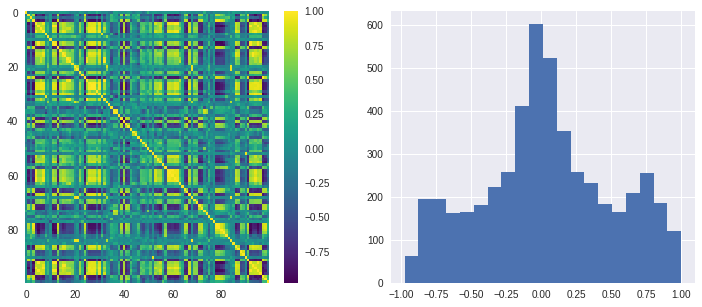

In [0]:
df_piv_clean, clustered_features = correlation_and_missing_data_analysis(df_piv, id_to_desc, _nan_frac_thresh=0.60, _cc_thresh=0.95)

From this analysis the following features in each cluster were kept:

- 57206 | Infant mortality rate (per 1,000 live births)
- 103606 | HDI: Income index (nanfrac=0.02)
- 69706 | HDI: Expected Years of Schooling (of children) (nanfrac=0.02)
- 136706 | Gross domestic product (GDP) per capita (2011 PPP $)
- 148306 | Employment to population ratio (% ages 15 and older)
- 178306 | Gross capital formation (% of GDP)

The population demographics were normalized, so that the population under age 5, age 15-64, and 65 and older were re-computed as fractions of the total population:
- 44206 | Population, total (millions)
- 132706 | Population, ages 65 and older (millions)
- 132806 | Population, under age 5 (millions)
- 63106 | Population aged 15-64 years, both sexes

In [0]:
# make list of feature ids to remove from highly correlated clusters
features_to_keep = [57206, 103606, 69706, 136706, 148306, 178306, 44206, 132706, 132806, 63106]
all_clustered_features = [int(x) for x in list(itertools.chain(*[grp for grp in clustered_features]))]
features_to_remove = np.setdiff1d(all_clustered_features, features_to_keep)

In [0]:
# remove the correlated features
for feature_id in features_to_remove:
  del df_piv_clean[str(feature_id)]

In [0]:
df_piv_clean.keys()

Index(['100806', '101606', '101706', '103606', '110906', '111106', '111306',
       '121206', '122006', '123506', '127606', '132706', '132806', '133006',
       '133206', '136706', '137906', '140606', '143306', '147206', '147906',
       '148306', '149206', '150606', '150706', '153706', '163906', '164406',
       '169706', '169806', '170006', '174206', '174306', '174406', '175106',
       '177706', '178306', '179406', '181206', '181706', '181806', '182206',
       '27706', '31706', '36806', '43006', '43606', '44206', '45106', '46006',
       '46106', '46206', '48706', '48806', '49006', '52606', '53506', '57206',
       '57906', '58006', '61006', '63106', '63206', '63306', '63406', '64306',
       '64406', '68606', '69706', '71606', '89006', '99106'],
      dtype='object')

Finally, the population columns are normalized:

In [0]:
denom_col = '44206'
cols_to_norm = ['132706', '132806', '63106']
for c in cols_to_norm:
  df_piv_clean[c] = df_piv_clean[c] / df_piv_clean[denom_col]

Three letter country codes were replaced with two letter codes:

In [0]:
# load the countries dataset
df_countries = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/country_codes.csv',
						               keep_default_na=False, na_values=['nan'])
c2_c3 = {row['Country2']:row['Country3'] for row_idx,row in df_countries.iterrows()}
c3_c2 = {row['Country3']:row['Country2'] for row_idx,row in df_countries.iterrows()}
cname_c2 = {row['Country']:row['Country2'] for row_idx,row in df_countries.iterrows()}
c2_cname = {row['Country2']:row['Country'] for row_idx,row in df_countries.iterrows()}
fips_c2 = {row['fips']:row['Country2'] for row_idx,row in df_countries.iterrows()}

df_piv_final = df_piv_clean.copy()
df_piv_final.reset_index(inplace=True)
df_piv_final['country2'] = df_piv_final['country3'].map(lambda x: c3_c2[str(x)] if x in c3_c2 else 'MISSING')

In [0]:
# drop missing countries
i = df_piv_final['country2'] == 'MISSING'
missing_countries = df_piv_final['country3'][i]
print('Dropping {} datapoints due to missing country code'.format(i.sum()))
print(missing_countries)

Dropping 7 datapoints due to missing country code
160     SSD
355     SSD
550     SSD
745     SSD
940     SSD
1135    SSD
1330    SSD
Name: country3, dtype: category
Categories (195, object): [AFG, AGO, ALB, AND, ..., YEM, ZAF, ZMB, ZWE]


In [0]:
del df_piv_final['country3']
df_piv_final.set_index(['year', 'country2'], inplace=True)

In [0]:
df_piv_final.to_csv('hdro_cleaned.csv', header=True, index=True, na_rep='nan')
files.download('hdro_cleaned.csv')

### Creating a Final Aggregate Country/Year Level Dataset

The goal in this section is to aggregate the aid/violence/poverty dataset with the Human Development Reports (HDRO) dataset. The main issue is that the HDRO dataset is limited to the years 2010-2016, while the aid/violence/poverty dataset spans a larger year range, from 2000-2017. Because the HDRO data is very rich, a decision was made to create a final aggregate dataset that spanned the years 2010-2016, so that insights could be gained on a country level for that time period.

In [0]:
# load HDRO dataset
df_hdro = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/hdro_cleaned.csv',
                     keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_hdro['country2'] = df_hdro['country2'].astype('category')
df_hdro['year'] = pd.to_datetime(df_hdro['year'], format='%Y-%m-%d')
df_hdro.set_index(['country2', 'year'], inplace=True)

# load population/poverty/aid/violence dataset that has been normalized by year
df_ppav = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/pop_pov_aid_vio_norm.csv',
                       keep_default_na=False, na_values=['nan', 'null', 'NaN', 'NULL'])
df_ppav['country2'] = df_ppav['country2'].astype('category')
df_ppav['year'] = pd.to_datetime(df_ppav['year'], format='%Y-%m-%d')
i = df_ppav['population'] == ''
df_ppav.loc[i, 'population'] = np.nan
df_ppav['population'] = df_ppav['population'].astype('float')

# limit the PPAV dataset to 
df_ppav.set_index(['country2', 'year'], inplace=True)

In [0]:

# limit the PPAV to years 2010-2016
i = (df_ppav.index.get_level_values('year') >= pd.to_datetime('2010', format='%Y')) & (df_ppav.index.get_level_values('year') <= pd.to_datetime('2016', format='%Y'))
print('Keeping {} rows of PPAV (originally {} rows)'.format(i.sum(), len(df_ppav)))

Keeping 1547 rows of PPAV (originally 4180 rows)


In [0]:
# merge the two datasets
df_ppav_hdro = pd.merge(df_ppav[i], df_hdro, left_index=True, right_index=True, how='outer')

In [0]:
# load the file with indicators in it
df = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/hdro_indicators.tsv', delimiter='\t')
id_to_desc = {str(row['indicator_id']):row['description'] for row_idx,row in df.iterrows()}

['population', 'human_aid', 'poverty', 'violent_num_mentions_frac', '100806', '101606', '101706', '103606', '110906', '111106', '111306', '121206', '122006', '123506', '127606', '132706', '132806', '133006', '133206', '136706', '137906', '140606', '143306', '147206', '147906', '148306', '149206', '150606', '150706', '153706', '163906', '164406', '169706', '169806', '170006', '174206', '174306', '174406', '175106', '177706', '178306', '179406', '181206', '181706', '181806', '182206', '27706', '31706', '36806', '43006', '43606', '44206', '45106', '46006', '46106', '46206', '48706', '48806', '49006', '52606', '53506', '57206', '57906', '58006', '61006', '63106', '63206', '63306', '63406', '64306', '64406', '68606', '69706', '71606', '89006', '99106']
NaN fractions
-------------
- Sex ratio at birth (male to female births): 0.64
- Youth not in school or employment (% ages 15-24): 0.63
- Primary school dropout rate (% of primary school cohort): 0.63
- Skilled labour force (% of labour force

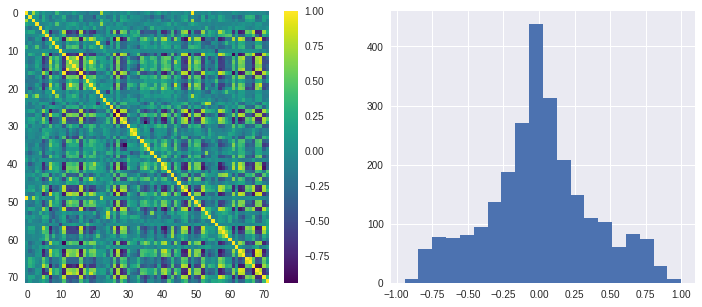

In [0]:
# analyze the correlations and nancounts
df_ppav_hdro_cleaned, clustered_features = correlation_and_missing_data_analysis(df_ppav_hdro, id_to_desc, _nan_frac_thresh=0.60, _cc_thresh=0.95, _skip_cols=['country_name'])

In [0]:
# drop correlated features
features_to_drop = ['44206', '121206', '122006']
for feature_id in features_to_drop:
  del df_ppav_hdro_cleaned[feature_id]

In one last step, the overall nan fraction of individual countries was computed, and a decision was made to exclude certain countries if more than 50% of their data points were nans:

In [0]:
nan_fractions = dict()
for cname,gdf in df_ppav_hdro_cleaned.groupby(['country_name']):  
  nan_frac = np.sum(gdf.isnull().sum().sum()) / np.prod(gdf.shape)  
  nan_fractions[cname] = nan_frac
print('Countries sorted by nan fraction')  
print('--------------------------------')
for cname,nanfrac in sorted(nan_fractions.items(), key=operator.itemgetter(1), reverse=True):
  print('{}: {:0.2f}'.format(cname, nanfrac))

Countries sorted by nan fraction
--------------------------------
Antarctica: 0.97
Bouvet Island: 0.97
British Indian Ocean Territory: 0.97
Christmas Island: 0.97
Heard Island and McDonald Islands: 0.97
Isle of Man: 0.97
Norfolk Island: 0.97
Pitcairn: 0.97
Svalbard and Jan Mayen: 0.97
United States Minor Outlying Islands: 0.97
American Samoa: 0.96
Faroe Islands: 0.96
Greenland: 0.96
Niue: 0.96
Saint Helena, Ascension and Tristan da Cunha: 0.96
US Virgin Islands: 0.96
Turks and Caicos Islands: 0.95
Aruba: 0.94
Bermuda: 0.94
British Virgin Islands: 0.94
Cayman Islands: 0.94
French Polynesia: 0.94
Gibraltar: 0.94
Guam: 0.94
Macau: 0.94
New Caledonia: 0.94
Northern Mariana Islands: 0.94
Puerto Rico: 0.94
Saint Martin: 0.94
Monaco: 0.80
Liechtenstein: 0.72
San Marino: 0.72
Andorra: 0.68
Nauru: 0.66
Tuvalu: 0.59
Marshall Islands: 0.59
Palau: 0.56
Saint Kitts and Nevis: 0.55
Micronesia: 0.49
Dominica: 0.49
North Korea: 0.48
Somalia: 0.47
Kiribati: 0.46
Antigua and Barbuda: 0.45
Grenada: 0.41


In [0]:
countries_to_drop = [cname for cname,nanfrac in nan_fractions.items() if nanfrac >= 0.50]
original_len = len(df_ppav_hdro_cleaned)
print('Dropping the following countries:')
print(countries_to_drop)
for cname in countries_to_drop:
  i = df_ppav_hdro_cleaned.country_name == cname
  df_ppav_hdro_cleaned = df_ppav_hdro_cleaned[~i]
print('Dataset went from {} rows to {}'.format(original_len, len(df_ppav_hdro_cleaned)))

Dropping the following countries:
['American Samoa', 'Andorra', 'Antarctica', 'Aruba', 'Bermuda', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Cayman Islands', 'Christmas Island', 'Faroe Islands', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guam', 'Heard Island and McDonald Islands', 'Isle of Man', 'Liechtenstein', 'Macau', 'Marshall Islands', 'Monaco', 'Nauru', 'New Caledonia', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Palau', 'Pitcairn', 'Puerto Rico', 'Saint Helena, Ascension and Tristan da Cunha', 'Saint Kitts and Nevis', 'Saint Martin', 'San Marino', 'Svalbard and Jan Mayen', 'Turks and Caicos Islands', 'Tuvalu', 'US Virgin Islands', 'United States Minor Outlying Islands']
Dataset went from 1554 rows to 1302


In [0]:
# save the dataset
df_ppav_hdro_cleaned.to_csv('ppav_hdro_cleaned.csv', header=True, index=True, na_rep='nan')
files.download('ppav_hdro_cleaned.csv')

### Aid Network Dataset

This dataset was constructed for GDELT events with base code '073', which from the [CAMEO codebook](http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf), means that the actors involved 

In [0]:
df = client.query('''
SELECT
Year AS year,
Actor1CountryCode AS actor1_country_code,
Actor2CountryCode AS actor2_country_code,
COUNT(EventRootCode) AS event_count,
SUM(NumMentions) AS num_mentions

FROM `gdelt-bq.full.events`

WHERE
MonthYear >= 200001 AND MonthYear <= 201812
AND ActionGeo_Type = 1
AND EventBaseCode = '073'
AND Actor1CountryCode <> Actor2CountryCode
AND Actor1CountryCode IS NOT NULL
AND Actor2CountryCode IS NOT NULL

GROUP BY Year,EventBaseCode,Actor1CountryCode,Actor2CountryCode

ORDER BY Year,EventBaseCode
''').to_dataframe()
df['year'] = pd.to_datetime(df['year'].astype('int').astype('str'), format='%Y')

In [0]:
df.to_csv('gdelt_human_aid_yearly.csv', index=False)
files.download('gdelt_human_aid_yearly.csv')

After construction of the initial dataset, there was some refinement to exclude countries that could not be mapped to their constituent two-letter codes. Then an undirected graph was constructed for each year, where the node was a country, and each edge represented the total number of events or mentions between countries:

In [0]:
# load the countries dataset
df_countries = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/country_codes.csv',
						               keep_default_na=False, na_values=['nan'])
c2_c3 = {row['Country2']:row['Country3'] for row_idx,row in df_countries.iterrows()}
c3_c2 = {row['Country3']:row['Country2'] for row_idx,row in df_countries.iterrows()}
cname_c2 = {row['Country']:row['Country2'] for row_idx,row in df_countries.iterrows()}
c2_cname = {row['Country2']:row['Country'] for row_idx,row in df_countries.iterrows()}
fips_c2 = {row['fips']:row['Country2'] for row_idx,row in df_countries.iterrows()}

# load the unprocessed graph dataset
df = pd.read_csv('https://raw.githubusercontent.com/mschachter/fun_with_gdelt/master/data/gdelt_human_aid_yearly.csv')
df['year'] = pd.to_datetime(df['year'], format='%Y-%m-%d')

# remove countries that don't have a two-letter code
u_countries = np.union1d(df['actor1_country_code'].unique(), df['actor2_country_code'].unique())
missing_countries = [x for x in u_countries if x not in c3_c2]
i = (df['actor1_country_code'].isin(missing_countries)) | (df['actor2_country_code'].isin(missing_countries))
df = df[~i]

# replace the three letter codes with two letter codes
df['actor1'] = df['actor1_country_code'].map(lambda x: c3_c2[x])
df['actor2'] = df['actor2_country_code'].map(lambda x: c3_c2[x])
del df['actor1_country_code']
del df['actor2_country_code']

# there is not necessarily any coherent directionality in the dataset, so an undirected
# graph can be built from it. group together the edges Country1-Country2 and Country2-Country1
# and sum up their values
df['edge_name'] = ['-'.join(sorted([row['actor1'], row['actor2']]))
						for row_idx,row in df.iterrows()]
df['edge_name'] = df['edge_name'].astype('category')
del df['actor1']
del df['actor2']

# now aggregate by year and edge, sum the events and mentions
df_graph = df.groupby(['year', 'edge_name']).aggregate(np.sum)
df_graph.reset_index(inplace=True)
nodes = [x.split('-') for x in df_graph['edge_name']]
df_graph['actor1'] = [x[0] for x in nodes]
df_graph['actor2'] = [x[1] for x in nodes]
del df_graph['edge_name']
i = np.isnan(df_graph['event_count']) | np.isnan(df_graph['num_mentions'])
df_graph = df_graph[~i]

# aggregate by year, to get the sum of event counts and mentions that can
# then be used as normalization factors
df_graph_yearly = df_graph.groupby('year').aggregate(np.sum)

# normalize the graph edges
for col in ['event_count', 'num_mentions']:
	df_graph[col] = [row[col] / df_graph_yearly.loc[row['year']][col] for row_idx,row in df_graph.iterrows()]
  
df_graph.sort_values(['year', 'actor1'], inplace=True)

In [0]:
df_graph.to_csv('gdelt_human_aid_graph.csv', index=False)
files.download('gdelt_human_aid_graph.csv')